<a href="https://colab.research.google.com/github/JuanMarcosRamirez/UDI_May2021/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XVII Jornadas de Internacionalización, República Oriental del Uruguay
## Técnicas Básicas de Máquinas de Aprendizaje en Teledetección

### Ejemplos de Clasificación de imágenes hiperespectrales
### **Autor:** Dr. Juan Marcos Ramírez Rondón
### 12 de Mayo de 2021

In [1]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/gdrive/


In [2]:
%cd "/content/gdrive/My Drive/Colab Notebooks/UDI_May2021"
%ls

/content/gdrive/My Drive/Colab Notebooks/UDI_May2021
Data/  hyperimgclasspkg.py  KNN.ipynb  __pycache__/  RF.ipynb  SVM.ipynb


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import hyperimgclasspkg as hiclass

# Cargar datos

In [4]:
# Carga la image Pavia University de tamaño 256 x 256

data_path    = os.path.join(os.getcwd(),'Data')
Io           = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
Io           = Io[354:610,0:256,0:96]
M, N, L      = Io.shape

ground_truth = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
ground_truth = ground_truth[354:610,0:256]

# Ajuste del ground truth o golden model
for i in range(0,M):
    for j in range(0,N):
        if (ground_truth[i,j] > 5):
            ground_truth[i,j] = ground_truth[i,j] - 1

# Crear los datos de entrenamiento y los datos de prueba

In [5]:
# Generar de forma aleatoria los indices de entrenamiento y los indices de prueba
# 10% muestras de entrenamiento, 90% muestras de prueba
trn_ind, tst_ind, num_trn, num_tst = hiclass.class_indices(ground_truth, 0.10)

Y_gtm  = ground_truth.reshape(M*N)
Y_trn  = Y_gtm[trn_ind]
Y_tst  = Y_gtm[tst_ind]

X_ftr  = Io.reshape(M*N, L)
X_trn  = X_ftr[trn_ind,:]
X_tst  = X_ftr[tst_ind,:]

# Etapa de clasificación y cálculo de precisión

In [6]:
# Entrenamiento y prueba del clasificador
svm = Pipeline([("scaler", StandardScaler()),
                ("linear_svc", LinearSVC(C=1, loss="hinge"))
                ])
svm.fit(X_trn, Y_trn)
Y_svm = svm.predict(X_tst)

# Cálculo de la precisióón
OA_svm, AA_svm, KP_svm, AC_svm = hiclass.compute_accuracy(Y_tst, Y_svm, verbose = True)


Class accuracy:
                  0.8643
                  0.9946
                  0.7627
                  0.7680
                  0.0108
                  0.3589
                  0.8530
                  0.9958

Overall accuracy: 0.9075
Average accuracy: 0.7010
kappa:            0.8380


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# Mostrar los mapas etiquetados

Text(0.5, 1.0, 'SVM. OA: 90.75')

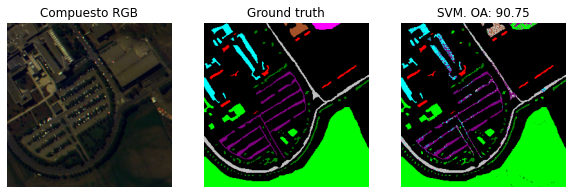

In [7]:
# Compuesto RGB de la image de interés
I_rgb = np.zeros((M,N,3),dtype=int)
I_rgb[:,:,0] =  255 * (Io[:,:,63].astype(float) - Io[:,:,63].min()) / (Io[:,:,63].max() - Io[:,:,63].min())
I_rgb[:,:,1] =  255 * (Io[:,:,31].astype(float) - Io[:,:,31].min()) / (Io[:,:,31].max() - Io[:,:,31].min())
I_rgb[:,:,2] =  255 * (Io[:,:,0].astype(float) - Io[:,:,0].min()) / (Io[:,:,0].max() - Io[:,:,0].min())

# Ground truth
gtm_img = hiclass.label2color_py(ground_truth,'paviaU')

# Mapa de Clasificación
lbl_svm = np.zeros(M*N, dtype=int)
lbl_svm[trn_ind] = Y_trn
lbl_svm[tst_ind] = Y_svm
svm_img = hiclass.label2color_py(lbl_svm.reshape(M,N),'paviaU')

fig, axs = plt.subplots(1,3)
fig.set_size_inches(10, 10)

axs[0].imshow(I_rgb)
axs[0].axis('off')
axs[0].set_title("Compuesto RGB")
axs[1].imshow(gtm_img)
axs[1].axis('off')
axs[1].set_title("Ground truth")
axs[2].imshow(svm_img)
axs[2].axis('off')
axs[2].set_title("SVM. OA: %.2f"%(OA_svm*100))

# plt.savefig('svm_classmap.png')